In [627]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display
from statsmodels import api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from toms_custom_functions import factorize_objects

''' Read in and examine data '''

# Set option to display all df columns
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

# Replace path with your own directory to re-run
my_path = "/Users/thomasfleming/Desktop/machine_learning"

# Read in mock dataset
df = pd.read_csv(f"{my_path}/Credit Card Defaulter Prediction.csv")

# View head of dataset, non-null count, and dtypes
display(df.head())
display(df.info())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,F,University,Married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,Y
1,2,120000,F,University,Single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,Y
2,3,90000,F,University,Single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,N
3,4,50000,F,University,Married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,N
4,5,50000,M,University,Married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,N


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         30000 non-null  int64 
 1   LIMIT_BAL  30000 non-null  int64 
 2   SEX        30000 non-null  object
 3   EDUCATION  30000 non-null  object
 4   MARRIAGE   30000 non-null  object
 5   AGE        30000 non-null  int64 
 6   PAY_0      30000 non-null  int64 
 7   PAY_2      30000 non-null  int64 
 8   PAY_3      30000 non-null  int64 
 9   PAY_4      30000 non-null  int64 
 10  PAY_5      30000 non-null  int64 
 11  PAY_6      30000 non-null  int64 
 12  BILL_AMT1  30000 non-null  int64 
 13  BILL_AMT2  30000 non-null  int64 
 14  BILL_AMT3  30000 non-null  int64 
 15  BILL_AMT4  30000 non-null  int64 
 16  BILL_AMT5  30000 non-null  int64 
 17  BILL_AMT6  30000 non-null  int64 
 18  PAY_AMT1   30000 non-null  int64 
 19  PAY_AMT2   30000 non-null  int64 
 20  PAY_AMT3   30000 non-null  i

None

In [628]:
''' Make changes to variables in df '''

# Drop ID, as we already have an index
df.drop(columns=["ID"], inplace=True)

# Factorize object data types
factorize_objects(df)

# Eliminate whitespace in any columns and convert to lower case
df.rename(str.strip, axis="columns", inplace=True)
df.rename(str.lower, axis="columns", inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   limit_bal  30000 non-null  int64
 1   sex        30000 non-null  int64
 2   education  30000 non-null  int64
 3   marriage   30000 non-null  int64
 4   age        30000 non-null  int64
 5   pay_0      30000 non-null  int64
 6   pay_2      30000 non-null  int64
 7   pay_3      30000 non-null  int64
 8   pay_4      30000 non-null  int64
 9   pay_5      30000 non-null  int64
 10  pay_6      30000 non-null  int64
 11  bill_amt1  30000 non-null  int64
 12  bill_amt2  30000 non-null  int64
 13  bill_amt3  30000 non-null  int64
 14  bill_amt4  30000 non-null  int64
 15  bill_amt5  30000 non-null  int64
 16  bill_amt6  30000 non-null  int64
 17  pay_amt1   30000 non-null  int64
 18  pay_amt2   30000 non-null  int64
 19  pay_amt3   30000 non-null  int64
 20  pay_amt4   30000 non-null  int64
 21  pay_amt5   3

In [629]:
''' Choose response variable to predict '''

# Set y to ChargeOff_Flag, since there are more charge-offs than late-stage delinquencies
y = df["default"]

# Set predictor matrix to include all fields except response variable
X = df.loc[:, ~df.columns.isin(["default"])]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [630]:
''' Get float variables and run Box-Tidwell test to evaluate linearity assumption '''

# Create list of continuous variables
cnt_var = ["limit_bal", "bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6",
    "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]

# Create df of continuous variables
df_cnt = df[cnt_var]

# Create interaction variables in df, training, and test sets
for var in cnt_var:
    df_cnt[f"{var}:log_{var}"] = df_cnt[f"{var}"] * np.log(df_cnt[f"{var}"])
    X_train[f"{var}:log_{var}"] = df_cnt[f"{var}:log_{var}"]
    X_test[f"{var}:log_{var}"] = df_cnt[f"{var}:log_{var}"]

# Manually performed backward stepwise selection, dropping the variable with the highest p-value over .01 each time
# until all p-values were signficant
X_cnst = sm.add_constant(X_train.loc[:, 
                                     ~X_train.columns.isin(["sex", "education", "marriage", "age",
                                                           "pay_0", "pay_1", "pay_2", "pay_3", "pay_4",
                                                           "pay_5", "pay_6", "bill_amt3:log_bill_amt3",
                                                           "pay_amt6:log_pay_amt6", "pay_amt6",
                                                           "pay_amt4:log_pay_amt4", "pay_amt4",
                                                           "bill_amt2:log_bill_amt2", "bill_amt2",
                                                           "bill_amt5", "bill_amt5:log_bill_amt5",
                                                           "bill_amt4:log_bill_amt4", "bill_amt4",
                                                           "pay_amt3:log_pay_amt3", "pay_amt3",
                                                           "pay_amt5:log_pay_amt5", "pay_amt5"])])

lm_cnt = sm.GLM(y_train, X_cnst, family=sm.families.Binomial(), missing="drop").fit()

print(lm_cnt.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                15837
Model:                            GLM   Df Residuals:                    15825
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7025.7
Date:                Sun, 23 Oct 2022   Deviance:                       14051.
Time:                        20:43:49   Pearson chi2:                 1.65e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [631]:
''' Drop insignificant interactions, as identified in Box-Tidwell '''

bt_drop_vars = ["bill_amt3:log_bill_amt3", "pay_amt6:log_pay_amt6",
                "pay_amt4:log_pay_amt4", "bill_amt2:log_bill_amt2",
                "bill_amt5:log_bill_amt5", "bill_amt4:log_bill_amt4",
                "pay_amt3:log_pay_amt3", "pay_amt5:log_pay_amt5"]

X_train.drop(columns=bt_drop_vars, inplace=True)
X_test.drop(columns=bt_drop_vars, inplace=True)

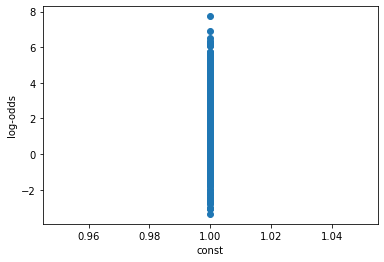

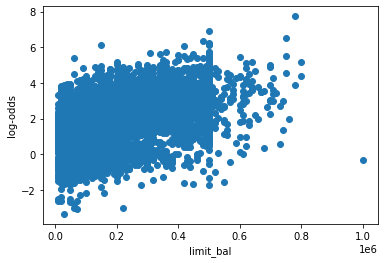

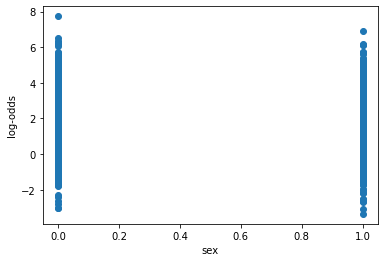

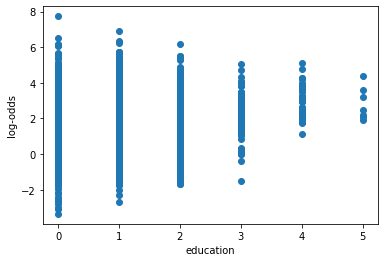

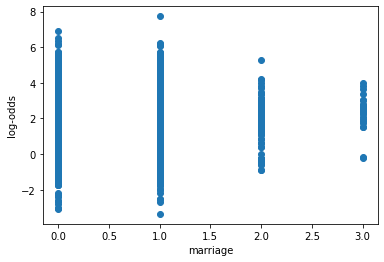

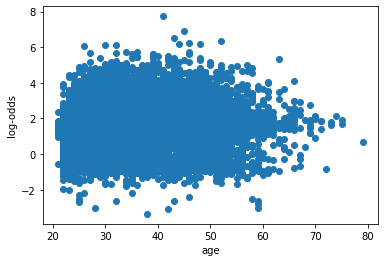

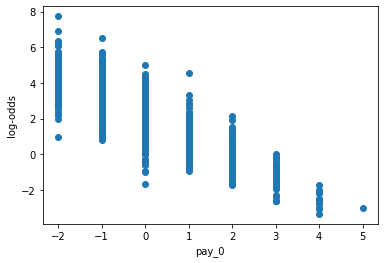

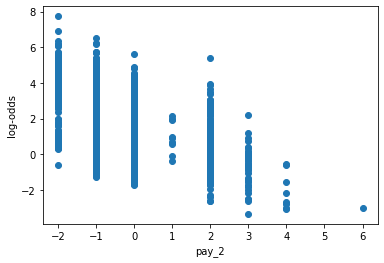

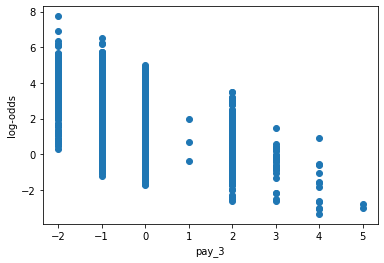

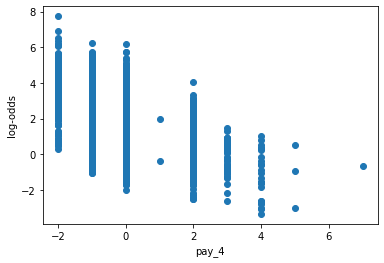

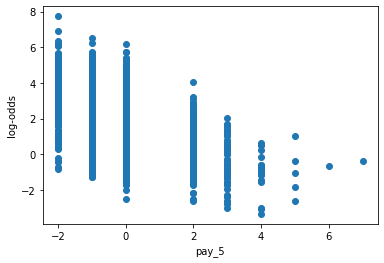

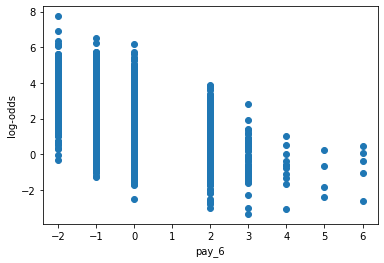

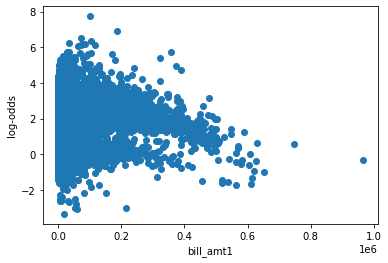

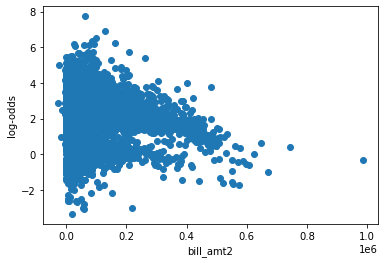

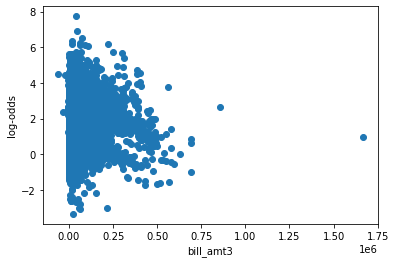

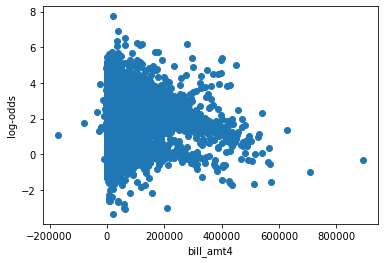

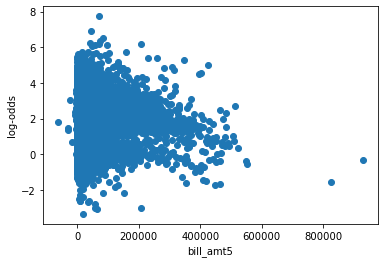

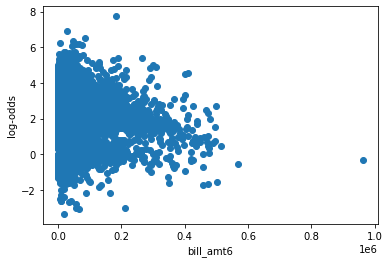

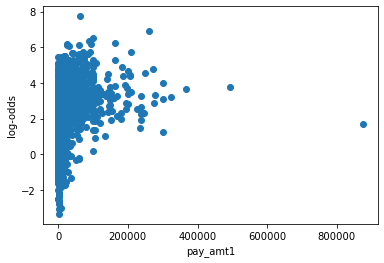

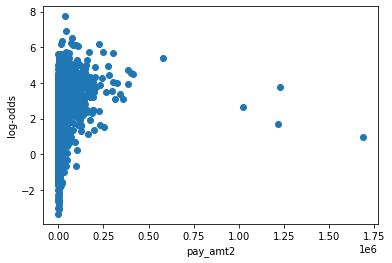

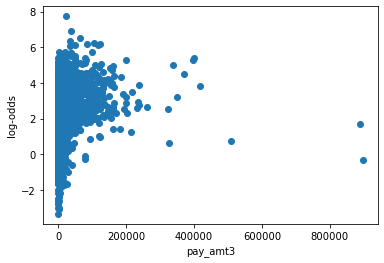

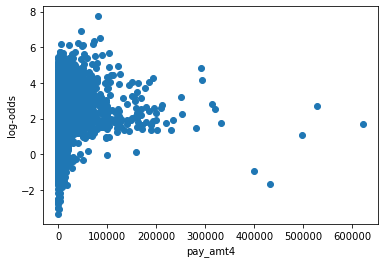

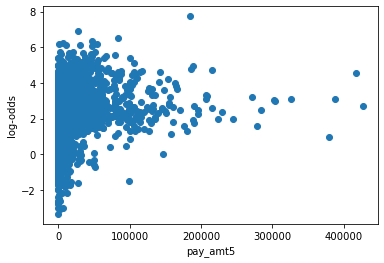

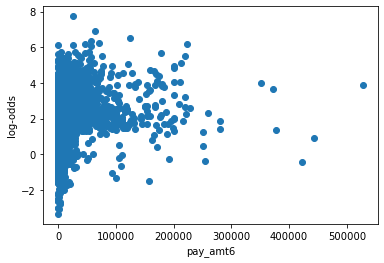

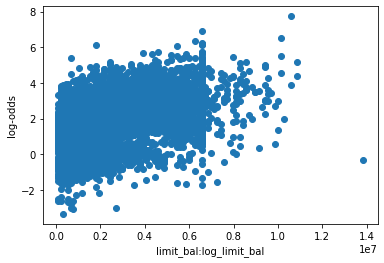

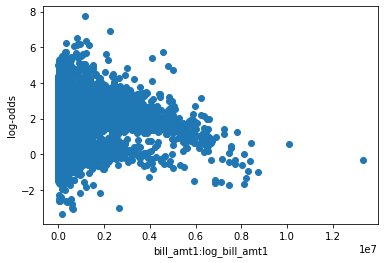

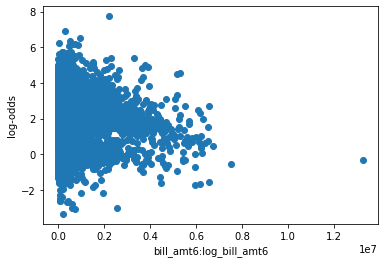

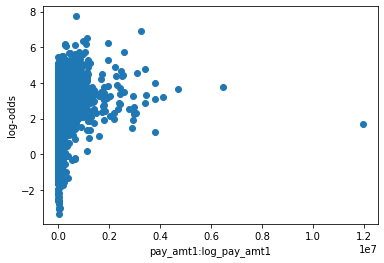

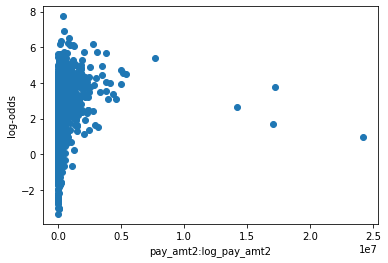

In [632]:
''' Visualize predictor variable versus log-odds for further check of linearity '''

X_cnst = sm.add_constant(X_train)
# Fit model and get predicted y values
lm_num = sm.GLM(y_train, X_cnst, family=sm.families.Binomial(), missing="drop").fit()
predicted = lm_num.predict(X_cnst)

# Calculated log-odds and add it to X_num
log_odds = np.log(predicted / (1 - predicted))

# Create plots of each predictor vs. log-odds
for var in X_cnst.columns.values:
    plt.scatter(x=X_cnst[var].values, y=log_odds)
    plt.xlabel(var)
    plt.ylabel("log-odds")
    plt.show()

In [633]:
''' Identify influential outliers '''

# Calculate Cook's Distance and set threshold
influence = lm_num.get_influence()
sum_df = influence.summary_frame()
diagnosis_df = sum_df[["cooks_d"]]
cook_threshold = 4 / (X_cnst.shape[0])

# Append absolute standardized residual values 
diagnosis_df['std_resid'] = stats.zscore(lm_num.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]

# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False)

,cooks_d,std_resid
11568,0.010258,4.365831
12829,0.010029,4.316149
28993,0.008976,7.043624
13477,0.008126,7.371487
6932,0.006969,6.854501
...,...,...
22640,0.000172,3.040810
6406,0.000172,3.427986
7433,0.000171,3.511671
9934,0.000171,3.171855


In [634]:
''' Remove influential outliers '''

inf_out = extreme.index.tolist()

X_train.drop(inf_out, inplace=True)
y_train.drop(inf_out, inplace=True)

In [636]:
''' Determine collinear variables with VIF '''
from toms_custom_functions import calculate_vif

X_vif = X_train.loc[:, ~X_train.columns.isin(["bill_amt1:log_bill_amt1", "bill_amt6:log_bill_amt6",
                                              "pay_amt1:log_pay_amt1", "pay_amt2:log_pay_amt2"])]
calculate_vif(X_vif, 10)

,variables,VIF
0,limit_bal,2280.648123
23,limit_bal:log_limit_bal,2098.501732
12,bill_amt2,39.975195
15,bill_amt5,36.392521
13,bill_amt3,32.014992
14,bill_amt4,28.830727
16,bill_amt6,21.588645
11,bill_amt1,21.018601


In [637]:
''' Remove collinear variables from VIF list using backward stepwise selection '''

X_train.drop(columns=["limit_bal", "bill_amt2", "bill_amt5", "bill_amt3", 
                      "bill_amt4"], inplace=True)

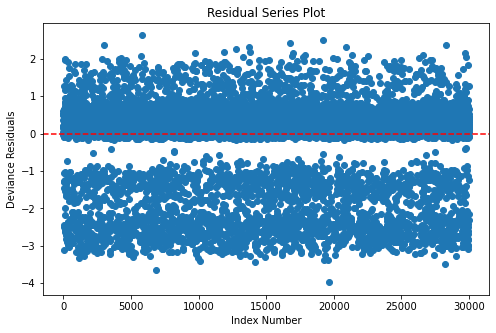

In [638]:
''' Verify independence of observations with residual series plot '''

X_cnst = sm.add_constant(X_train)

# Fit model and get predicted y values
lm_int = sm.GLM(y_train, X_cnst, family=sm.families.Binomial(), missing="drop").fit()

# Setup plot 
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                     xlabel="Index Number", 
                     ylabel="Deviance Residuals")

# Generate residual series plot using standardized deviance residuals
ax.scatter(X_cnst.dropna().index.tolist(), stats.zscore(lm_int.resid_deviance))

# Draw horizontal line at y=0
plt.axhline(y = 0, ls="--", color='red');

In [639]:
''' Fit the model and display the summary '''

X_num = sm.add_constant(X_train.loc[:, ~X_train.columns.isin(["pay_amt1", "pay_amt2",
                                                              "pay_amt3", "pay_amt4",
                                                              "pay_amt5", 
                                                              "pay_amt6"])])

# Set up final dfs and fit model
lm_final = sm.GLM(y_train, X_num, family=sm.families.Binomial(), missing="drop").fit()

print(lm_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                15591
Model:                            GLM   Df Residuals:                    15573
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5475.3
Date:                Sun, 23 Oct 2022   Deviance:                       10951.
Time:                        20:44:48   Pearson chi2:                 1.60e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Accuracy score: 82.43%
Recall: 99.82%
Precision: 82.55%
F1 Score: 90.37%


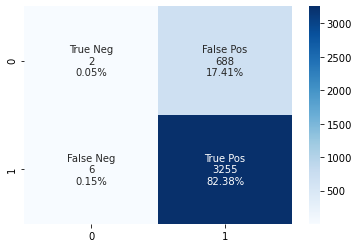

In [640]:
''' Make prediction on test set'''

lm = LogisticRegression()

X_reg = X_train.dropna()

lm.fit(X_reg, y_train[X_reg.index.values])

X_val = X_test.loc[:, ~X_test.columns.isin(["limit_bal", "bill_amt2", "bill_amt5", "bill_amt3", "bill_amt4"])].dropna()
predictions = lm.predict(X_val)

y_val = y_test[X_val.index.values]

cf_matrix = confusion_matrix(y_val, predictions)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

accuracy_score = "{0:.2%}".format(accuracy_score(y_val, predictions))
recall = "{0:.2%}".format(recall_score(y_val, predictions))
precision = "{0:.2%}".format(precision_score(y_val, predictions))
f1_score = "{0:.2%}".format(f1_score(y_val, predictions))
print(f"Accuracy score: {accuracy_score}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")